In [198]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
%autoreload 2

In [200]:
%cd ..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE


In [201]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_1d, plot_1d_distribution
from tqdm.notebook import trange
import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

The KL between q and p is 112.818 nats.


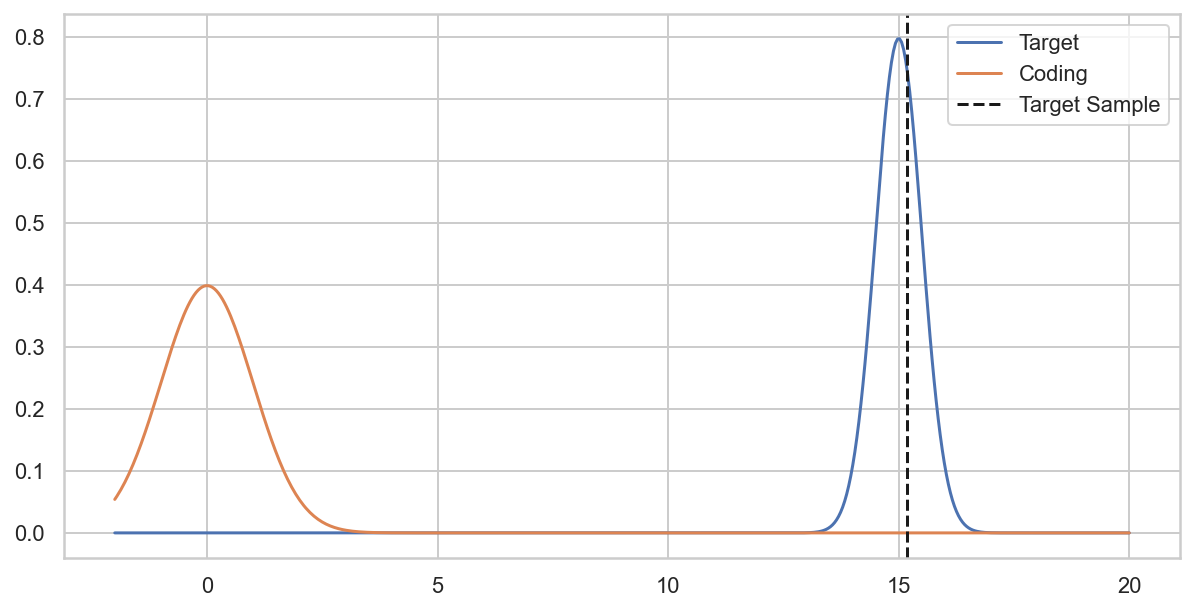

In [329]:
torch.manual_seed(100)

q_loc = 15.
q_var = 0.25

p_loc = 0.
p_var = 1.

q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
p = dist.normal.Normal(loc=p_loc, scale = math.pow(p_var, 0.5))

z_sample = q.sample()

total_kl = dist.kl_divergence(q, p)

print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================

xs = torch.linspace(-2., 20., 500)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')

ax.axvline(z_sample, c='k', ls='--', label='Target Sample')

ax.legend()

plt.show()

## Using Empirical Samples

The aim is to encode a sample from $q$ using coding distribution $p$. To make things easier we approximate $q$ with a convinient form. Instead of usign a variational factored Gaussian posterior, we can use an empirical posterior by sampling $z_1, ..., z_D \sim q(z |\mathcal{D})$. Then we can set our approximate distribution to 
$$
\begin{aligned}
\hat{q}(z) = \frac{1}{D} \sum_{i=1}^{D} \delta_{z_i} (z).
\end{aligned}
$$

For the REC scheme we need to compute,

$$
\begin{aligned}
\hat{q}(a_k \mid a_{1:k-1}) 
&= \int \hat{q}(a_k \mid a_{1:k-1}, z) \hat{q}(z\mid a_{1:k-1}) \text{ d}z \\
&= \int p(a_k \mid a_{1:k-1}, z) \hat{q}(z\mid a_{1:k-1}) \text{ d}z 
\end{aligned}
$$

The final equality is due to our target distribution satifying the condition that the KL between $q$ and $p$ is equal when using either $z$ or auxiliary variables, namely that both 
$$
\hat{q}\left(a_{k} \mid a_{1: k-1}, z\right)=p\left(a_{k} \mid a_{1: k-1}, z\right) \quad \text { and } \quad \hat{q}\left(a_{1: k} \mid z\right)=p\left(a_{1: k} \mid z\right)
$$

To compute the posterior above, note that both
$$
\begin{aligned}
\hat{q}(z \mid a_{1:k-1}) 
&= \frac{\hat{q}(a_{1:k-1} \mid z)\hat{q}(z)}{\hat{q}(a_{1:k-1})}
\end{aligned}
$$


which follows from Bayes' rule, and
$$
\begin{aligned}
\hat{q}(a_{1:k-1}) 
&= \int \hat{q}(a_{1:k-1} \mid z) \hat{q}(z) \text{ d}z \\
&= \int p(a_{1:k-1} \mid z) \hat{q}(z) \text{ d}z
\end{aligned}
$$
which again follows from assurances on the KL.

Substituting the form of $\hat{q}$ defined earlier we find that,
$$
\begin{aligned}
\hat{q}(a_{1:k-1}) 
&= \int p(a_{1:k-1} \mid z) \frac{1}{D} \sum_{i=1}^{D} \delta_{z_i} (z) \text{ d}z \\
&= \frac{1}{D} \sum_{i=1}^{D} p(a_{1:k-1} \mid z_i).
\end{aligned}
$$

Therefore, substituting this back into the posterior on $z$,
$$
\begin{aligned}
\hat{q}(z \mid a_{1:k-1}) 
&= \frac{\hat{q}(a_{1:k-1} \mid z)\hat{q}(z)}{\hat{q}(a_{1:k-1})} \\
&= \frac{p(a_{1:k-1} \mid z)\hat{q}(z)}{\hat{q}(a_{1:k-1})} \\ 
& = \frac{p(a_{1:k-1} \mid z)\frac{1}{D} \sum_{i=1}^{D} \delta_{z_i} (z)}{\frac{1}{D} \sum_{i=1}^{D} p(a_{1:k-1} \mid z_i)} \\
&= \sum_{i=1}^{D} \delta_{z_i}(z) \frac{p(a_{1:k-1} \mid z_i)}{\sum_{j=1}^{D} p(a_{1:k-1} \mid z_j)}.
\end{aligned}
$$

Altogether, we can substitute back into the integrals defined earlier to find the posterior on the auxiliary variable $a_k$ as,

$$
\begin{aligned}
\hat{q}(a_k \mid a_{1:k-1}) 
&= \int p(a_k \mid a_{1:k-1}, z) \hat{q}(z\mid a_{1:k-1}) \text{ d}z \\
&= \int p(a_k \mid a_{1:k-1}, z) \sum_{i=1}^{D} \delta_{z_i}(z) \frac{p(a_{1:k-1} \mid z_i)}{\sum_{j=1}^{D} p(a_{1:k-1} \mid z_j)} \text{ d}z \\
&= \sum_{i=1}^{D} \frac{p(a_{1:k-1} \mid z_i)}{\sum_{j=1}^{D} p(a_{1:k-1} \mid z_j)} p(a_k \mid a_{1:k-1}, z_i).
\end{aligned}
$$

This defines a mixture of Gaussian with mixing weight $\frac{p(a_{1:k-1} \mid z_i)}{\sum_{j=1}^{D} p(a_{1:k-1} \mid z_j)}$ and each component distributed by $p(a_k \mid a_{1:k-1}, z_i)$.

# Implementing the scheme

In [480]:
omega = 8.
epsilon = 0.
num_empirical_samples = 100
num_aux = math.ceil(total_kl / omega)
num_samples_per_aux = math.ceil(math.exp(omega * (1. + epsilon)))
print(f"The KL is {total_kl:.3f} and Omega: {omega}."
      f"\n So num auxiliaries: {num_aux} and num samples per aux: {num_samples_per_aux}.")

The KL is 112.818 and Omega: 8.0.
 So num auxiliaries: 15 and num samples per aux: 2981.


In [481]:
def p_ak_given_traj_and_z(aux_traj, z_samples, auxiliary_vars, total_var):

    b_k = torch.sum(aux_traj)
    s_k_minus_one = total_var - torch.sum(auxiliary_vars[:-1])
    s_k = s_k_minus_one - auxiliary_vars[-1]

    mean_scalar = auxiliary_vars[-1] / s_k_minus_one
    variance = auxiliary_vars[-1] * s_k / s_k_minus_one

    mean = (z_samples - b_k) * mean_scalar

    return mean, variance

In [482]:
def gmm_mixing_weights(aux_traj_log_probs):
    """Takes p(a_k | a_{1:k-1}, z_i) for each z_i and computes the GMM mixing weights"""
    return torch.softmax(aux_traj_log_probs, dim=0)

In [483]:
def q_ak_given_traj(component_means, component_vars, mixing_weights):
    
    mixing_categorical = dist.categorical.Categorical(probs=mixing_weights)
    
    component_gaussians = dist.normal.Normal(loc=component_means, scale=torch.sqrt(component_vars))
    
    gmm = dist.mixture_same_family.MixtureSameFamily(mixing_categorical, component_gaussians)
    
    return gmm

In [484]:
# For omega = 8 we have 'optimised variances', otherwise uniform does okay
if omega == 8:
    auxiliary_vars = torch.tensor([0.0750, 0.0722, 0.0712, 0.0709, 0.0710, 0.0712, 0.0715, 0.0713, 0.0714,
            0.0718, 0.0717, 0.0700, 0.0647, 0.0556, 0.0204])
else:
    auxiliary_vars = p_var * torch.ones(num_aux) / num_aux

total_var = p_var
torch.manual_seed(100)
z_samples = q.sample((num_empirical_samples,))
aux_traj = torch.zeros([0])
aux_traj_mixing_weights = torch.ones((num_empirical_samples,))
aux_traj_log_q = torch.zeros(1)
aux_traj_log_p = torch.zeros(1)
biggest_sample = torch.zeros(1)
pbar = trange(1, num_aux + 1)
for i in pbar:
    torch.manual_seed(i)
    if i < num_aux:
        # first compute the prior
        aux_prior = dist.normal.Normal(loc=0., scale=math.pow(auxiliary_vars[i-1], 0.5))

        # compute the posterior
        mixing_weights = gmm_mixing_weights(aux_traj_mixing_weights)

        means, variances = p_ak_given_traj_and_z(aux_traj, z_samples, auxiliary_vars[:i], total_var)
        trial_samples = aux_prior.sample((num_samples_per_aux,))

        aux_post = q_ak_given_traj(means, variances, mixing_weights)

        # sample trial aks
        trial_samples = aux_prior.sample((num_samples_per_aux,))
        
        biggest_sample += torch.max(trial_samples)

        # compute log probabilities under prior and posterior
        log_p = aux_prior.log_prob(trial_samples)
        log_q = aux_post.log_prob(trial_samples)

        # compute the joint probability of the full trajectories
        log_p_joint = log_p + aux_traj_log_p 
        log_q_joint = log_q + aux_traj_log_q

        # compute log importance sampling weight log(q/p)
        log_importance_sampling_weight = log_q_joint - log_p_joint

        # greedily choose the best weight
        best_sample_idx = torch.argmax(log_importance_sampling_weight)

        # compute the corresponding sample
        best_sample = trial_samples[best_sample_idx]

        # append to trajectory
        aux_traj = torch.cat([aux_traj, best_sample[None]])
        aux_traj_log_p += log_p[best_sample_idx]
        aux_traj_log_q += log_q[best_sample_idx]

        # compute the new mixing weights by adding new component densities to old joint component densities
        aux_traj_mixing_weights += aux_post.component_distribution.log_prob(best_sample)
    
    else:
        # last sample we complete the sum and choose best sample under q

        # first compute the prior
        aux_prior = dist.normal.Normal(loc=0., scale=math.pow(auxiliary_vars[-1], 0.5))

        # sample trial aKs
        trial_samples = aux_prior.sample((num_samples_per_aux,))
        biggest_sample += torch.max(trial_samples)
        
        # complete the sum
        final_trial_zs = torch.sum(aux_traj, dim=0) + trial_samples

        # compute log q
        log_q = q.log_prob(final_trial_zs)

        # choose best sample
        best_sample_idx = torch.argmax(log_q)

        best_sample = trial_samples[best_sample_idx]

        aux_traj = torch.cat([aux_traj, best_sample[None]])
    
    #print(f"Best sample for aux {i} was {best_sample}")
    pbar.set_description(f"Encoded Auxiliary Variable {i}")

  0%|          | 0/15 [00:00<?, ?it/s]

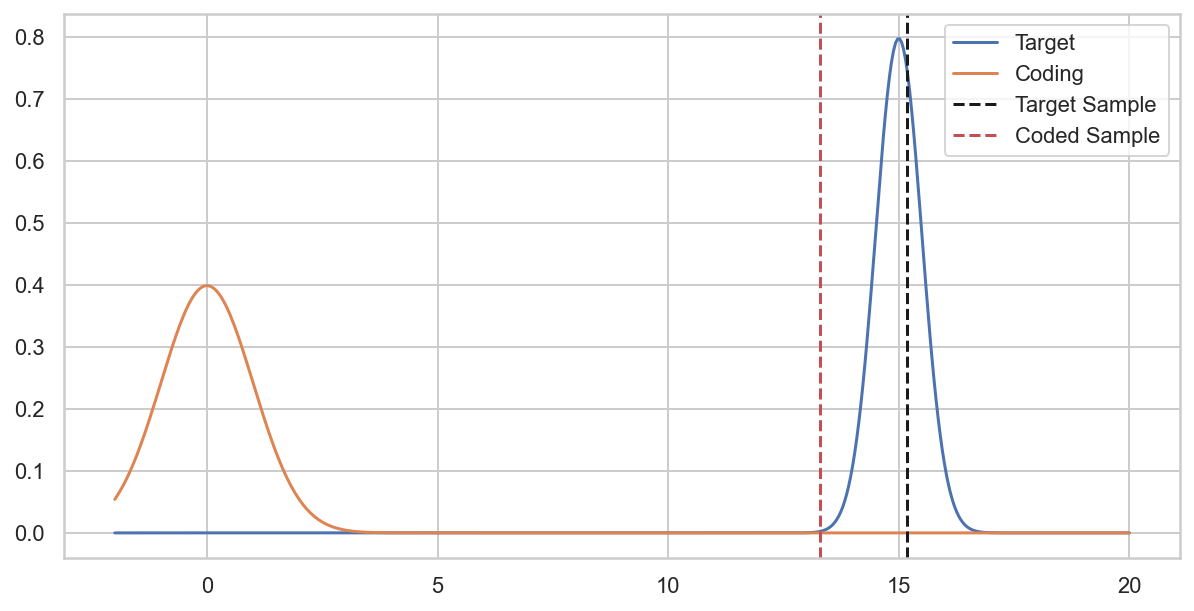

In [485]:
final_z_sum = torch.sum(aux_traj)

# ==============================
# PLOT DISTRIBUTIONS
# ==============================

xs = torch.linspace(-2., 20., 500)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')

ax.axvline(z_sample, c='k', ls='--', label='Target Sample')
ax.axvline(final_z_sum, c='r', ls='--', label='Coded Sample')
ax.legend()

plt.show()

In [486]:
final_z_sum

tensor(13.2831)

In [487]:
biggest_sample

tensor([13.2831])